In [2]:
!pip install langdetect

In [3]:
!pip install nltk

In [4]:
!pip install spacy

In [5]:
!pip install wordcloud

In [6]:
import pandas as pd
import numpy as np
from langdetect import detect #detecção do idioma
from textblob import TextBlob #detecção do idioma
import time
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import nltk
from nltk import tokenize
import spacy

import random

from nltk.cluster import KMeansClusterer
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score, silhouette_samples

In [7]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     C:\Users\User\A

[nltk_data]    |   Package swadesh is already up-to-date!
[nltk_data]    | Downloading package switchboard to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package switchboard is already up-to-date!
[nltk_data]    | Downloading package timit to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package timit is already up-to-date!
[nltk_data]    | Downloading package toolbox to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package toolbox is already up-to-date!
[nltk_data]    | Downloading package treebank to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package treebank is already up-to-date!
[nltk_data]    | Downloading package twitter_samples to
[nltk_data]    |     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]    |   Package twitter_samples is already up-to-date!
[nltk_data]    | Downloading package udhr to
[nltk_data]    |     C:\U

True

In [8]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [9]:
nlp = spacy.load('en_core_web_sm')

Funções auxiliares

In [10]:
# referencia: https://pbpython.com/currency-cleanup.html
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [11]:
def identificar_idioma(palavra):
    idioma = 'Não identificado'
    if type(palavra) is str:
        nu_letras = len([i for i in palavra if i.isalpha()])
        if nu_letras >3:
            idioma = detect(palavra)
    return idioma  
            

In [12]:
# transformação das palavras em radicai
def stem_sentences(sentence):
    stemmer = nltk.stem.RSLPStemmer()
    
    tokens = [palavra.lemma_ for palavra in nlp(sentence)]
    #tokens = sentence.split()
    stemmed_tokens = [stemmer.stem(token).lower() for token in tokens]
    return ' '.join(stemmed_tokens)

In [13]:
def listar_palavras(dataframe, coluna):
    return' '.join([str(texto) for texto in dataframe[coluna]])

In [14]:
def word_cloud(dataframe, coluna, altura=15, largura=10):
    #texto = dataframe
    palavras = listar_palavras(dataframe, coluna)
    nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110,
                          collocations = False).generate(palavras)  
    plt.figure(figsize=(altura,largura))
    plt.imshow(nuvem_palavras, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()
    return plt

In [15]:
def grafico_barras(dataframe, coluna, qtd_top_palavras = 15, altura=10, largura=30):
    palavras = listar_palavras(dataframe, coluna)
    token_espaco = tokenize.WhitespaceTokenizer()
    frequencia = nltk.FreqDist(token_espaco.tokenize(palavras))
    
    df_frequencia = pd.DataFrame({"Palavra":list(frequencia.keys()),
                             "Frequência": list(frequencia.values())})
    
    df_frequencia = df_frequencia.nlargest(columns="Frequência", n=qtd_top_palavras)
    plt.figure(figsize=(largura, altura))
    ax = sns.barplot(data=df_frequencia, x="Palavra", y="Frequência", color='gray')
    ax.set(ylabel="Contagem")
    plt.show()


In [16]:
def word_cloud_grupo(dataframe, coluna_palavras="comments_stem", coluna_cluster="grupos"):
    grupos = dataframe[coluna_cluster].unique().tolist()
    grupos.sort()
    for g in grupos:
        print("Word cloud grupo", g)
        filtro = dataframe[coluna_cluster]==g
        word_cloud(dataframe[filtro], coluna_palavras)


In [17]:
def analise_silhueta(dataframe, X, colunas_grupos =["grupo_kmeans", "grupo_hierarquico"]):
    df = []
    for g in colunas_grupos:
        silh = silhouette_score(X,dataframe[g].values, metric='cosine')
        df.append({"Método": g.split("_")[-1],
                   "Mínimo":np.min(silh), 
                   "Mediana":np.median(silh),
                   "Média":np.mean(silh),
                   "Máximo": np.max(silh)})
    return pd.DataFrame(df)

In [18]:
def clustering_kmeans(nu_clusters, X, repeticoes=20):
    modelo = KMeansClusterer(nu_clusters
                             ,distance=nltk.cluster.util.cosine_distance
                             ,repeats=repeticoes
                             ,rng=random.Random(14)
                             ,avoid_empty_clusters=True)
    labels_kmeans = modelo.cluster(X, assign_clusters=True)
    return labels_kmeans

def clustering_hierarquico(nu_clusters, X, repeticoes=20):
    modelo = AgglomerativeClustering(n_clusters=nu_clusters,affinity='cosine', linkage="average").fit(X)
    labels_hierarquico = modelo.labels_
    return labels_hierarquico

Parâmetros

In [19]:
max_palavras = 1000
freq_min_palavras = 0.05

# Extração dos dados

In [20]:
df_reviews = pd.read_csv("inputs/reviews.csv")
print("REVIEWS")
print("Entradas:\t {}".format(df_reviews.shape[0]))
print("Variáveis:\t {}\n".format(df_reviews.shape[1]))
df_reviews.head()

REVIEWS
Entradas:	 47425
Variáveis:	 6



,listing_id,id,date,reviewer_id,reviewer_name,comments
0,73282,1304820,2012-05-19,1787723,Jeff,Simona was an excellent hostess. The apartment...
1,73282,1448861,2012-06-10,2183393,Rick,"The apartment was fantastic - clean, beautiful..."
2,73282,1574534,2012-06-27,2343568,Joseph,I stayed in the apartment for two weeks with m...
3,73282,1745571,2012-07-19,2343192,Yvonne,The apartment was everything and more. spaciou...
4,73282,2026650,2012-08-19,2092762,Joy,Simona's place is great! It's very quiet and ...


# ETL

Identificando o idioma em cada comentário, pois como iremos agrupar os comentários, então é necessário escolher um idioma específico para realizar o tratamento do texto.

In [21]:
#df_reviews = df_reviews.sample(1000)

In [22]:
ini_tempo = time.time()
df_reviews["language"] = df_reviews.comments.apply(identificar_idioma)
fim_tempo = time.time()
print(fim_tempo-ini_tempo, "s")

234.9854531288147 s


Analisando as quantidades e porcentagens

In [23]:
df_reviews.language.value_counts().nlargest(10)

en                  35642
de                   6233
fr                   1564
es                    947
ko                    568
zh-cn                 475
it                    405
Não identificado      275
pt                    210
ro                    155
Name: language, dtype: int64

In [24]:
df_reviews.language.value_counts(normalize=True).nlargest(10)

en                  0.751545
de                  0.131429
fr                  0.032978
es                  0.019968
ko                  0.011977
zh-cn               0.010016
it                  0.008540
Não identificado    0.005799
pt                  0.004428
ro                  0.003268
Name: language, dtype: float64

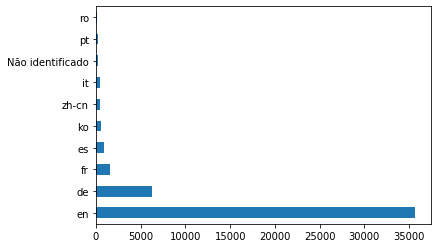

In [25]:
df_reviews.language.value_counts().nlargest(10).plot.barh()

Como eseprado, notamos que a maioria dos comentários, cerca de 75%, são em inglês. Logo, iremos filtrar esses comentários.

In [26]:
df_reviews = df_reviews[df_reviews.language == 'en']
df_reviews.head()
print("Entradas:\t {}".format(df_reviews.shape[0]))

Entradas:	 35642


# Análise do texto

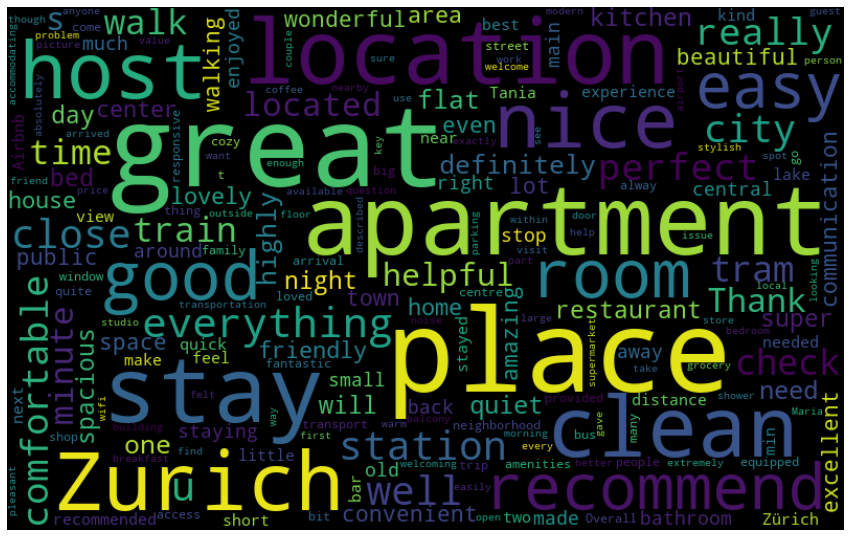

<module 'matplotlib.pyplot' from 'C:\\Users\\User\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [27]:
word_cloud(df_reviews, "comments")

Aplicando 'stemming' nas palavras, ou seja, padronizando as palavras para evitar que no momento da criação dos tokens uma mesma palavra aplicada de maneira diferente seja considerada mais de uma vez. Por exemplo, o verbo 'play' pode ser conjugado no texto como 'played' ou 'playing', após o tratamento todas as ocorrências se resumirão em 'play.

In [28]:
ini_tempo = time.time()
df_reviews["comments_stem"] = df_reviews.comments.apply(stem_sentences)
fim_tempo = time.time()
print(fim_tempo-ini_tempo, "s")

484.5084295272827 s


Criando o objeto que será responsável pela criação dos tokens, ou seja, colunas indicando a ocorrência dos termos em cada linha. Vale ressaltar que foi utilizado o método Tf-idf para atribuir uma ponderação do termo para cada comentário.

In [29]:
vectorizer = TfidfVectorizer(max_features=max_palavras
                             ,min_df=freq_min_palavras
                             ,stop_words="english"
                             ,strip_accents='unicode'
                             , ngram_range=(1, 2))

Criando os tokens

In [30]:
bag_of_words = vectorizer.fit_transform(df_reviews.comments_stem)

Criando o data frame 

In [31]:
vetorizado = pd.DataFrame.sparse.from_spmatrix(bag_of_words, columns=vectorizer.get_feature_names())

Adicionar um prefixo no nome das colunas

In [32]:
vetorizado.columns =  ['token_'+i.replace(" ", "_") for i in vetorizado.columns]

In [33]:
vetorizado.head()
print("Variáveis:\t {}\n".format(vetorizado.shape[1]))

Variáveis:	 80



Concatenando os dataframes

In [34]:
df_reviews = pd.concat([df_reviews.reset_index(drop=True), vetorizado.reset_index(drop=True)], axis='columns')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,language,comments_stem,token_als,token_amazing,...,token_thil,token_thil_plac,token_tim,token_town,token_tr,token_train,token_train_station,token_walk,token_wonderful,token_zurich
0,73282,1304820,2012-05-19,1787723,Jeff,Simona was an excellent hostess. The apartment...,en,sim be an excellent hostes . the apartment be ...,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.236960,0.00000,0.000000,0.0,0.0,0.33818
1,73282,1448861,2012-06-10,2183393,Rick,"The apartment was fantastic - clean, beautiful...",en,"the apartment be fantastic - clean , beautiful...",0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.00000
2,73282,1574534,2012-06-27,2343568,Joseph,I stayed in the apartment for two weeks with m...,en,i stay in the apartment for two week with my w...,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.00000
3,73282,1745571,2012-07-19,2343192,Yvonne,The apartment was everything and more. spaciou...,en,"the apartment be everything and mor . spaci , ...",0.000000,0.0,...,0.0,0.0,0.0,0.0,0.268842,0.27852,0.306546,0.0,0.0,0.00000
4,73282,2026650,2012-08-19,2092762,Joy,Simona's place is great! It's very quiet and ...,en,sim 's plac be great ! it be very quiet and ...,0.257947,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.00000


Reduzindo a dimensionalidade

In [35]:
pca = PCA(n_components=0.95)

In [36]:
X = pca.fit_transform(vetorizado.values)
print('Redução de dimensionalidade: ',len(X[0]))

Redução de dimensionalidade:  69


Calculando a métrica da silhueta para escolher qual método e cluster será escolhido

In [37]:
df = []
for g in range(2, 6):
    print(g, "grupos")
    labels_kmeans = clustering_kmeans(nu_clusters=g,X=X)
    silh_kmeans = silhouette_samples(X,labels_kmeans, metric='cosine')
    print("\t KMeans calculado!")
    labels_hierarquico = clustering_hierarquico(nu_clusters=g, X=X)
    silh_hierarquico = silhouette_samples(X,labels_hierarquico, metric='cosine')
    print("\t Hierarquico calculado!")
    df.append({"Número de Clusters":g,
               "Mínimo KMeans":np.min(silh_kmeans), 
               "Mediana KMeans":np.median(silh_kmeans),
               "Média KMeans":np.mean(silh_kmeans),
               "Máximo KMeans": np.max(silh_kmeans),
               "Mínimo Hierárquico":np.min(silh_hierarquico), 
               "Mediana Hierárquico":np.median(silh_hierarquico),
               "Média Hierárquico":np.mean(silh_hierarquico),
               "Máximo Hierárquico": np.max(silh_hierarquico)})

df_silh = pd.DataFrame(df)

2 grupos
	 KMeans calculado!
	 Hierarquico calculado!
3 grupos
	 KMeans calculado!
	 Hierarquico calculado!
4 grupos
	 KMeans calculado!
	 Hierarquico calculado!
5 grupos
	 KMeans calculado!
	 Hierarquico calculado!


In [38]:
df_silh

,Número de Clusters,Mínimo KMeans,Mediana KMeans,Média KMeans,Máximo KMeans,Mínimo Hierárquico,Mediana Hierárquico,Média Hierárquico,Máximo Hierárquico
0,2,-0.002615,0.044221,0.052124,0.241398,-0.352845,0.045588,0.038029,0.456118
1,3,-0.023470,0.047375,0.059403,0.329502,-0.351555,0.024335,0.027182,0.449594
2,4,-0.037047,0.048538,0.061777,0.361049,-0.349811,0.013305,0.024149,0.449594
3,5,-0.058475,0.055596,0.074047,0.386948,-0.349811,0.013552,0.025549,0.449594


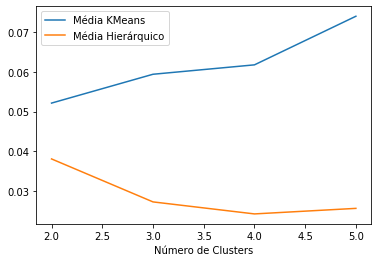

In [39]:
df_silh.plot(x="Número de Clusters",y=["Média KMeans", "Média Hierárquico"])

Método e número de clusters escolhido

In [40]:
df_reviews["grupo_hierarquico"] = clustering_hierarquico(4,X)

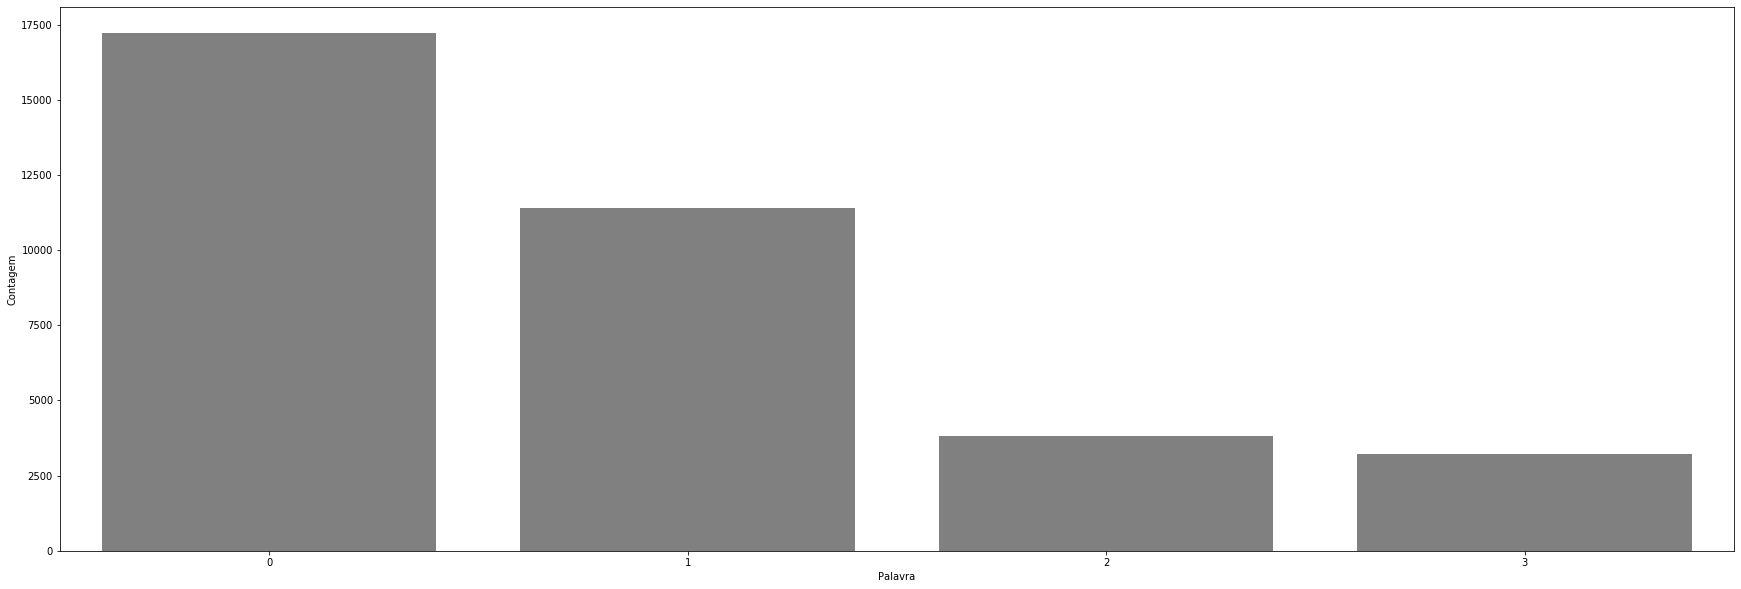

In [41]:
grafico_barras(df_reviews, "grupo_hierarquico")

Word cloud grupo 0


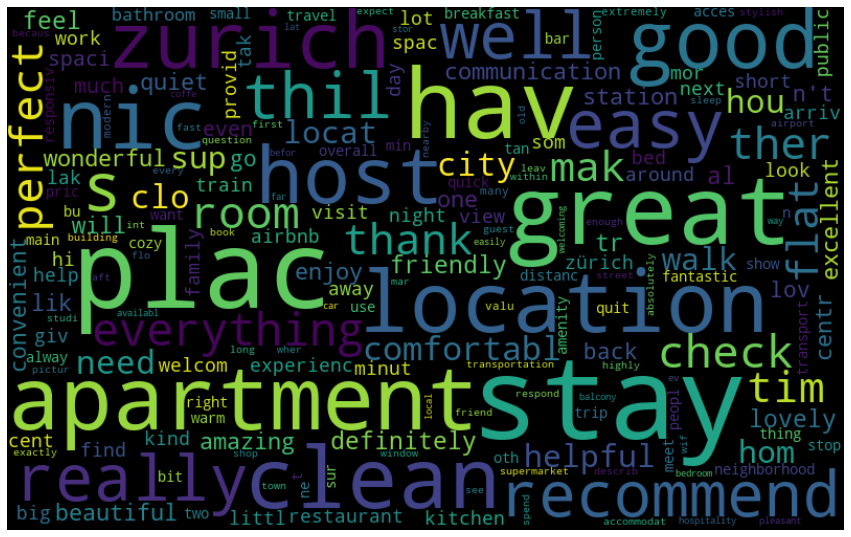

Word cloud grupo 1


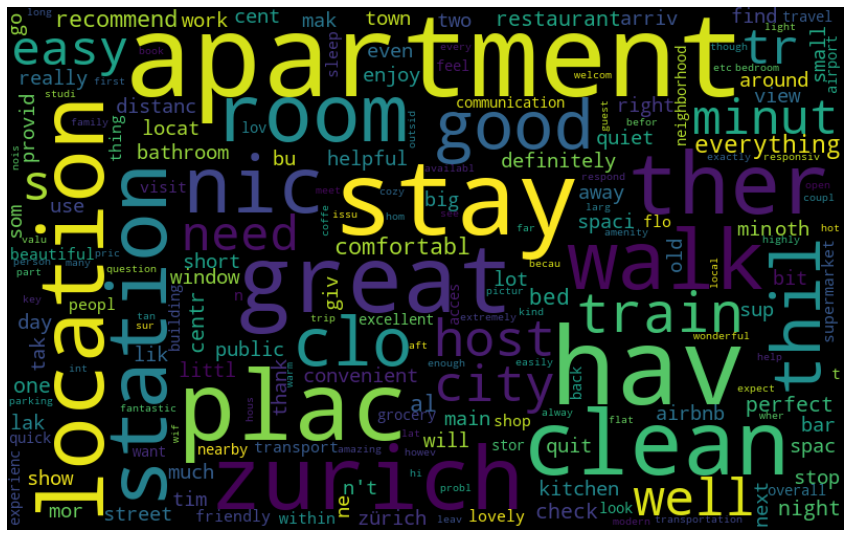

Word cloud grupo 2


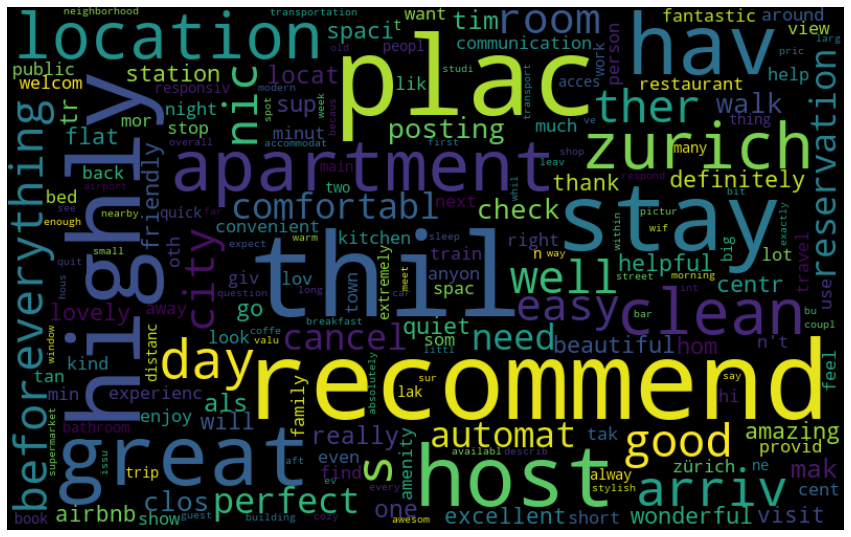

Word cloud grupo 3


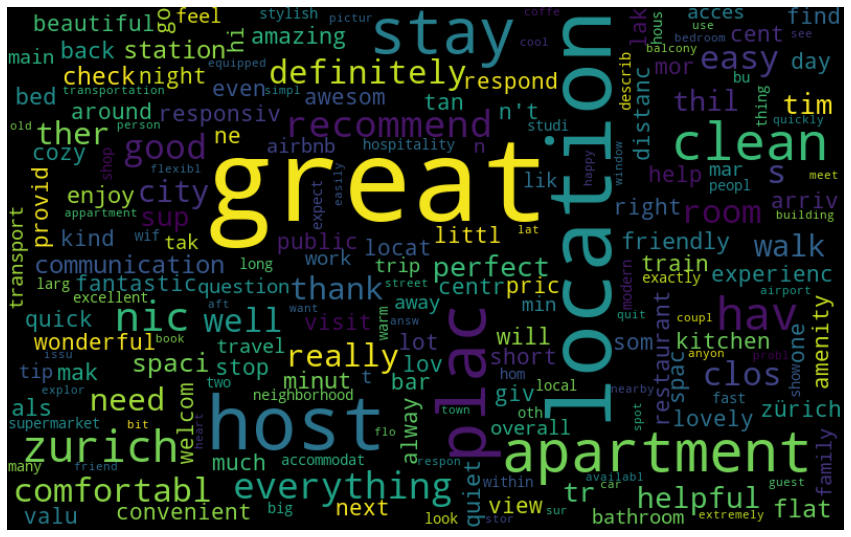

In [42]:
word_cloud_grupo(df_reviews, "comments_stem", "grupo_hierarquico")